In [15]:
# import the necessary packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from imutils import paths
import numpy as np
import pandas as pd
import argparse
import imutils
import cv2
import os
import math
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

In [16]:
def image_to_feature_vector(image, size=(64, 64)):
	# resize the image to a fixed size, then flatten the image into
	# a list of raw pixel intensities
	return cv2.resize(image, size).flatten()

In [17]:
def extract_color_histogram(image, bins=(8, 8, 8)):
	# extract a 3D color histogram from the HSV color space using
	# the supplied number of `bins` per channel
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
		[0, 180, 0, 256, 0, 256])

	# handle normalizing the histogram if we are using OpenCV 2.4.X
	if imutils.is_cv2():
		hist = cv2.normalize(hist)

	# otherwise, perform "in place" normalization in OpenCV 3 (I
	# personally hate the way this is done
	else:
		cv2.normalize(hist, hist)

	# return the flattened histogram as the feature vector
	return hist.flatten()

======================================================================================================
# Load and Cleanup Data
======================================================================================================

In [18]:
dataset = "./classes/kNN_data/"
# grab the list of images that we'll be describing
print("[INFO] describing images...")
imagePaths = list(paths.list_images(dataset))
print "[INFO] " + str(len(list(paths.list_images(dataset)))) + " images found!"

[INFO] describing images...
[INFO] 6000 images found!


In [19]:
# initialize the raw pixel intensities matrix, the features matrix,
# and labels list
rawImages = []
features = []
labels = []

# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
	# load the image and extract the class label (assuming that our
	# path as the format: /path/to/dataset/{class}.{image_num}.jpg
	image = cv2.imread(imagePath)
	label = imagePath.split(os.path.sep)[-1].split(".")[0]

	# extract raw pixel intensity "features", followed by a color
	# histogram to characterize the color distribution of the pixels
	# in the image
	pixels = image_to_feature_vector(image)
	hist = extract_color_histogram(image)

	# update the raw images, features, and labels matricies,
	# respectively
	rawImages.append(pixels)
	features.append(hist)
	labels.append(label)

	# show an update every 1,000 images
	if i > 0 and i % 1000 == 0:
		print("[INFO] processed {}/{}".format(i, len(imagePaths)))

[INFO] processed 1000/6000
[INFO] processed 2000/6000
[INFO] processed 3000/6000
[INFO] processed 4000/6000
[INFO] processed 5000/6000


In [20]:
from collections import Counter
Counter(labels)

Counter({'adidas': 1500, 'jordan': 1500, 'newbalance': 1500, 'nike': 1500})

======================================================================================================
# PCA on Dataset
======================================================================================================

In [21]:
## Get 10 principal components
pca = PCA(n_components=10)
pca.fit(rawImages)
images_transformed = pca.transform(rawImages)

0.63199319735947546

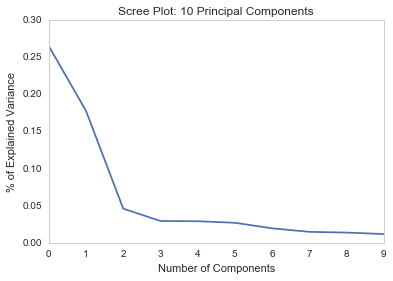

In [22]:
plt.plot(pca.explained_variance_ratio_)
plt.title("Scree Plot: 10 Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("% of Explained Variance")
sum(pca.explained_variance_ratio_)

======================================================================================================
# Train the kNN Model
======================================================================================================

In [23]:
#64*64*3 colors
# rawImages: Images flattened to a single list
# labels: Brands for the given images
# features: Color histogram

X_train, X_val, Y_train, Y_val = cross_validation.train_test_split(images_transformed,
                                                                   labels, 
                                                                   test_size=.1, 
                                                                   random_state=1337)
print "Length of Validation Set:" + str(len(Y_val))
print "Length of Train Set:" + str(len(Y_train))
print "Ratio: " + str(len(Y_val) / float(len(Y_train)))

Length of Validation Set:600
Length of Train Set:5400
Ratio: 0.111111111111


In [24]:
## Train the KNN model
print "Training KNN Model..."
## n_jobs=-1: Use all cores
## n_neighbors = Number of Neighbors
n_neighbors = math.ceil(math.sqrt(len(images_transformed)))

model = KNeighborsClassifier(n_neighbors=n_neighbors,
                             weights = 'distance',
                             n_jobs=-1)
model.fit(X_train, Y_train)

Training KNN Model...


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=78.0, p=2,
           weights='distance')

In [25]:
model2 = KNeighborsClassifier(n_neighbors=n_neighbors,
                             n_jobs=-1)
model2.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=78.0, p=2,
           weights='uniform')

In [26]:
## Predict on the validation set using the KNN model.
validations_predictions = model.predict(X_val)
print validations_predictions

['nike' 'nike' 'jordan' 'jordan' 'newbalance' 'newbalance' 'nike'
 'newbalance' 'adidas' 'newbalance' 'nike' 'jordan' 'jordan' 'adidas'
 'newbalance' 'adidas' 'adidas' 'nike' 'jordan' 'nike' 'jordan' 'nike'
 'adidas' 'newbalance' 'jordan' 'nike' 'adidas' 'jordan' 'nike'
 'newbalance' 'newbalance' 'newbalance' 'newbalance' 'nike' 'newbalance'
 'jordan' 'jordan' 'adidas' 'adidas' 'jordan' 'newbalance' 'newbalance'
 'newbalance' 'adidas' 'jordan' 'newbalance' 'newbalance' 'nike' 'jordan'
 'newbalance' 'jordan' 'jordan' 'newbalance' 'newbalance' 'newbalance'
 'newbalance' 'newbalance' 'jordan' 'newbalance' 'newbalance' 'adidas'
 'jordan' 'jordan' 'nike' 'jordan' 'jordan' 'jordan' 'newbalance'
 'newbalance' 'newbalance' 'adidas' 'newbalance' 'nike' 'newbalance'
 'newbalance' 'jordan' 'newbalance' 'jordan' 'newbalance' 'newbalance'
 'adidas' 'newbalance' 'jordan' 'newbalance' 'newbalance' 'nike'
 'newbalance' 'jordan' 'nike' 'adidas' 'newbalance' 'newbalance' 'nike'
 'jordan' 'jordan' 'nike'

/Users/waihamyee/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:72: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]


In [27]:
## Can be used for visualizing misclassifications!
results = pd.DataFrame()

results.insert(0,'actual',Y_val)
results.insert(1,'predictions',validations_predictions)

misclassified = results[results['actual'] != results['predictions']].count()[0] / float(len(X_val))
misclassified

0.43666666666666665

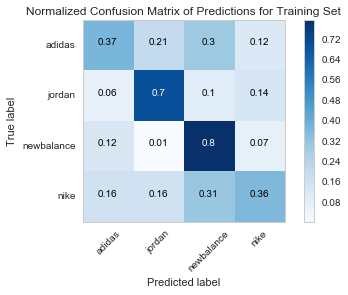

In [46]:
## Plot the confusion matrix for the new data predictions
classes = list(set(labels))
classes.sort()

cm = confusion_matrix(Y_val, validations_predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix of Predictions for Training Set")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, round(cm[i, j],2),
             horizontalalignment="center",
             color="white" if round(cm[i, j]) > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [29]:
## Give me the 5 nearest neighbors of the first two items in the validation set
pd.DataFrame(model.kneighbors(X_val[0:5], n_neighbors=5, return_distance=False))

,0,1,2,3,4
0,741,1611,467,4836,93
1,991,1360,210,155,34
2,4884,1861,1964,105,2536
3,4100,2733,827,331,1201
4,4038,1986,4710,4064,4022


In [30]:
## Look at the nearest neighbors for the data
dataset = "./classes/kNN_data/"
imagePaths = list(paths.list_images(dataset))
imagePaths.sort()

print imagePaths[0]

print imagePaths[741]
print imagePaths[1611]
print imagePaths[467]
print imagePaths[4836]
print imagePaths[93]

#8699
# imagePaths.index('./classes/kNN_data/adidas.12.png')
# model.kneighbors(new_images_test[1], n_neighbors=107, return_distance=False)

./classes/kNN_data/adidas.10.png
./classes/kNN_data/adidas.2647.png
./classes/kNN_data/jordan.11093.png
./classes/kNN_data/adidas.14580.png
./classes/kNN_data/nike.10842.png
./classes/kNN_data/adidas.10975.png


In [31]:
model.score(X_val,Y_val)

0.56333333333333335

In [32]:
model.score(X_train,Y_train)

1.0

In [33]:
model2.score(X_val,Y_val)

0.53166666666666662

In [34]:
model2.score(X_train,Y_train)

0.55351851851851852

======================================================================================================
# Testing on New Data
======================================================================================================

In [35]:
new_images_test = []
new_labels = []
newDataPath = list(paths.list_images("./classes/kNN_new_data/"))
newDataPath.sort()

for (i, newDataPath) in enumerate(newDataPath):    
    image = cv2.imread(newDataPath)
    new_images = image_to_feature_vector(image)
    
    nlabels = newDataPath.split(os.path.sep)[-1].split(".")[0]
    new_images_test.append(new_images)
    new_labels.append(nlabels)

In [36]:
from collections import Counter
Counter(new_labels)

Counter({'adidas': 8, 'jordan': 8, 'newbalance': 18, 'nike': 9})

In [37]:
new_images_transformed = pca.transform(new_images_test)

0.63199319735947546

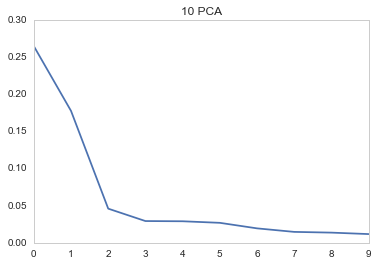

In [38]:
plt.plot(pca.explained_variance_ratio_)
plt.title("10 PCA")
sum(pca.explained_variance_ratio_)

In [39]:
new_data_predictions = model.predict(new_images_transformed)
rslt = new_labels == new_data_predictions
new_data_df = pd.DataFrame()

new_data_df.insert(0,'actual',new_labels)
# new_data_df.insert(1, 'image_name', map(lambda x: x.split(os.path.sep)[-1], newDataPath[0:len(new_labels)]))
new_data_df.insert(1,'predictions',new_data_predictions)
new_data_df.insert(2,'results',rslt)


print "Accuracy of the Model:" + str(model.score(new_images_transformed, new_labels))

new_data_df

Accuracy of the Model:0.511627906977


,actual,predictions,results
0,adidas,jordan,False
1,adidas,jordan,False
2,adidas,adidas,True
3,adidas,jordan,False
4,adidas,jordan,False
5,adidas,jordan,False
6,adidas,adidas,True
7,adidas,jordan,False
8,jordan,jordan,True
9,jordan,newbalance,False


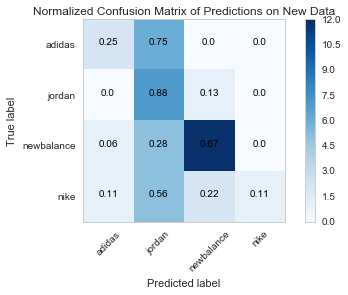

In [48]:
## Plot the confusion matrix for the new data predictions
classes = list(set(new_labels))
classes.sort()

cm = confusion_matrix(new_labels, new_data_predictions)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix of Predictions on New Data")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
thresh = cm.max() / 2.
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, round(cm[i, j],2),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [41]:
prediction_nearest_neighbors = pd.DataFrame(model.kneighbors(new_images_transformed[1], n_neighbors=5, return_distance=False))
prediction_nearest_neighbors

/Users/waihamyee/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


,0,1,2,3,4
0,3965,2127,4657,2215,4062


In [42]:
## Translate the predicted nearest neighbors
newDataPath = list(paths.list_images("./classes/kNN_new_data/"))
newDataPath.sort()

print newDataPath[0]

print imagePaths[3965]
print imagePaths[2127]
print imagePaths[4657]
print imagePaths[2215]
print imagePaths[4062]

./classes/kNN_new_data/adidas.1.png
./classes/kNN_data/newbalance.720.png
./classes/kNN_data/jordan.15453.png
./classes/kNN_data/nike.10388.png
./classes/kNN_data/jordan.15790.png
./classes/kNN_data/newbalance.7658.png


In [43]:
newDataPath = list(paths.list_images("./classes/kNN_new_data/"))
newDataPath

['./classes/kNN_new_data/adidas.1.png',
 './classes/kNN_new_data/adidas.2.png',
 './classes/kNN_new_data/adidas.3.png',
 './classes/kNN_new_data/adidas.4.png',
 './classes/kNN_new_data/adidas.5.png',
 './classes/kNN_new_data/adidas.6.png',
 './classes/kNN_new_data/adidas.7.png',
 './classes/kNN_new_data/adidas.8.png',
 './classes/kNN_new_data/jordan.1.png',
 './classes/kNN_new_data/jordan.2.png',
 './classes/kNN_new_data/jordan.3.png',
 './classes/kNN_new_data/jordan.4.png',
 './classes/kNN_new_data/jordan.5.png',
 './classes/kNN_new_data/jordan.6.png',
 './classes/kNN_new_data/jordan.7.png',
 './classes/kNN_new_data/jordan.8.png',
 './classes/kNN_new_data/newbalance.10.png',
 './classes/kNN_new_data/newbalance.13.png',
 './classes/kNN_new_data/newbalance.14.png',
 './classes/kNN_new_data/newbalance.16.png',
 './classes/kNN_new_data/newbalance.18.png',
 './classes/kNN_new_data/newbalance.2.png',
 './classes/kNN_new_data/newbalance.20.png',
 './classes/kNN_new_data/newbalance.23.png',
 

In [44]:
nearest_neighbors = list(model.kneighbors(new_images_transformed[2], n_neighbors=76, return_distance=False)[0])
NN_images = [imagePaths[x] for x in nearest_neighbors]

processNN = map(lambda x: x.split(os.path.sep)[-1].split(".")[0], NN_images)
[ (i,processNN.count(i)) for i in set(processNN) ]


/Users/waihamyee/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[('newbalance', 28), ('jordan', 17), ('adidas', 17), ('nike', 14)]